In [8]:
import cobra
from cobra.flux_analysis import flux_variability_analysis
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
#from matplotlib.patches import Patch
#from matplotlib import colors as mcolors
import numpy as np
import pandas as pd
#import seaborn as sns
import os
from cameo import phenotypic_phase_plane
import pickle
import openpyxl

In [2]:
def add_fixed_constraint(model, rxn, value):
    """
    model = cobra formatted model
    rxn = string of reaction id
    value = a single int/float to constrain the reaction to, or a list/tuple like (lb, ub)
    """
    try:
        lower = value[0]
        upper = value[1]
    except (TypeError, IndexError):
        lower = value
        upper = value
    constraint = model.problem.Constraint(
        getattr(model.reactions, rxn).flux_expression,
        lb=lower, ub=upper)
    model.add_cons_vars(constraint)
    return constraint
def create_rxn(model, name, cpd_dict, direction="both", limits=None):
    # Create a reaction from a dict with {"CPD1": -1, "CPD2: 1"}
    # Assuming the cpd ids are already in the model
    if direction not in ["forward", "reverse", "both"]:
        raise ValueError("Direction must be either forward, reverse, or both")
    rxn = cobra.Reaction(name)
    if limits is not None:
        if len(limits) != 2:
            raise ValueError("Limits must be of length 2")
        else:
            rxn.lower_bound = limits[0]
            rxn.upper_bound = limits[1]
    elif direction == "both":
        rxn.lower_bound = -1000
        rxn.upper_bound = 1000
    elif direction == "forward":
        rxn.lower_bound = 0
        rxn.upper_bound = 1000
    else:
        rxn.lower_bound = -1000
        rxn.upper_bound = 0
    rxn.add_metabolites({
        getattr(model.metabolites, cpd): val for cpd, val in cpd_dict.items()
    })
    print("Adding the following reaction to model:")
    print(rxn)
    model.add_reactions([rxn])

In [3]:
cobra_config = cobra.Configuration()
cobra_config.solver = "cplex"

In [4]:
with open("../sbmls/b971180d_YM_closed.sbml") as f:
    YM_closed = cobra.io.read_sbml_model(f)
with open("../sbmls/b971180d_YM_open.sbml") as f:
    YM_open = cobra.io.read_sbml_model(f)
with open("../sbmls/b971180d_YM_CODH_closed.sbml") as f:
    CODH_closed = cobra.io.read_sbml_model(f)
with open("../sbmls/b971180d_YM_CODH_open.sbml") as f:
    CODH_open = cobra.io.read_sbml_model(f)

'' is not a valid SBML 'SId'.
'' is not a valid SBML 'SId'.
'' is not a valid SBML 'SId'.
'' is not a valid SBML 'SId'.


## Universal constraints
1. GAPDH is removed in glycolytic conditions
2. GAPOR is removed in gluconeogenic conditions
3. OE-Adhf limits on ethanol production (See Fig3 notebook)

## Specific constraints
1. Maltose uptake is constrained to the maximum

In [5]:
for model in [YM_closed, YM_open]:
    model.reactions.R01061.upper_bound = 0
    model.reactions.R01063.upper_bound = 0

In [6]:
#OE-AdhF constraints
YM_closed.reactions.TP_ETOH.lower_bound = 3.29265
YM_open.reactions.TP_ETOH.lower_bound = 0.6934
CODH_closed.reactions.TP_ETOH.lower_bound = 3.29265
CODH_open.reactions.TP_ETOH.lower_bound = 0.6934

## Figure 7
Product envelopes, closed model
These are calculated on the fly by the cameo phenotypic_phase_plane function

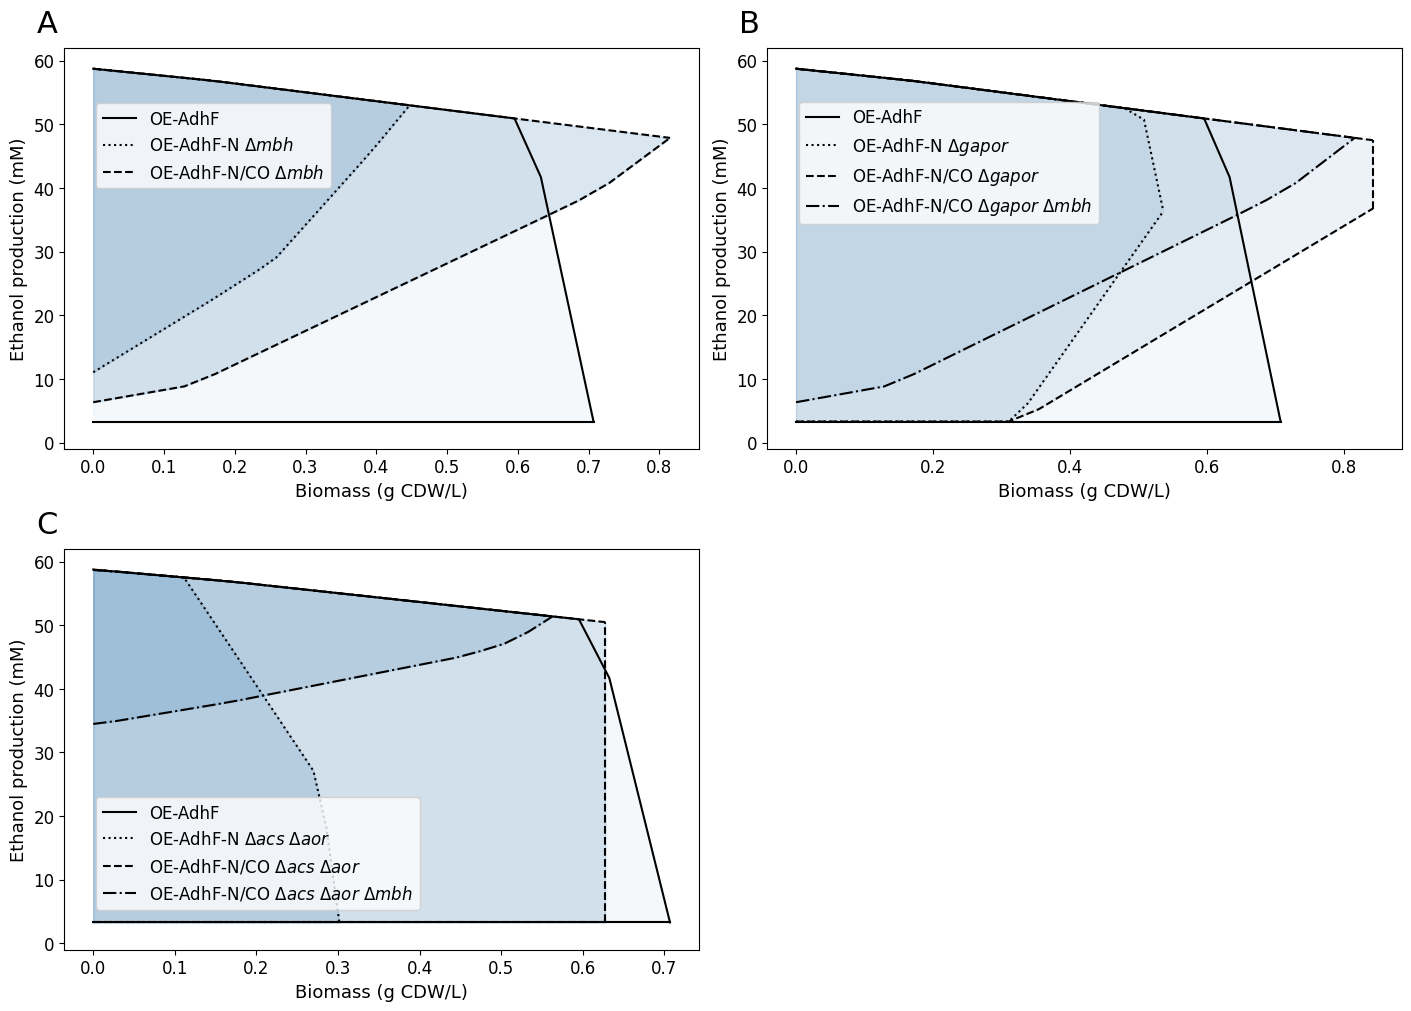

In [9]:
%%capture --no-display
YM = YM_closed
CODH = CODH_closed
mal_upt = float(flux_variability_analysis(YM, "MalABC").maximum)
with plt.rc_context({"figure.figsize": (14, 10), "font.size": 12}):
    fig, axes = plt.subplot_mosaic([["A", "B"], ["C", "."]], constrained_layout=True)
    ################### base model
    model = YM.copy()  
    add_fixed_constraint(model, "MalABC", mal_upt)
    result = phenotypic_phase_plane(model,
                                    variables=[model.reactions.Biomass_Pfu],
                                    objective=model.reactions.TP_ETOH,
                                    points=20)
    df = result.data_frame[["Biomass_Pfu", "objective_lower_bound", "objective_upper_bound"]]
    axes["A"].plot(df.Biomass_Pfu, df.objective_lower_bound, linestyle="solid", color="black", label="OE-AdhF")
    axes["A"].plot(df.Biomass_Pfu, df.objective_upper_bound, linestyle="solid", color="black")
    axes["A"].plot([df.Biomass_Pfu[-1:], df.Biomass_Pfu[-1:]], [df.objective_lower_bound[-1:], df.objective_upper_bound[-1:]], color="black", linestyle="solid")
    axes["A"].fill_between(df.Biomass_Pfu, df.objective_upper_bound, df.objective_lower_bound, alpha=0.05, color="steelblue")
    base_biomass = float(df.Biomass_Pfu[-1:])
    ####################### OE-AdhF-N ΔMBH
    model = YM.copy()
    add_fixed_constraint(model, "MalABC", mal_upt)
    create_rxn(model, "R01058", {"C00118": -1, "C00006": -1, "C00001": -1, "C00197": 1, "C00005": 1, "C00080": 1}, direction="forward")
    model.remove_reactions(["mbh"])
    result = phenotypic_phase_plane(model,
                                    variables=[model.reactions.Biomass_Pfu],
                                    objective=model.reactions.TP_ETOH,
                                    points=20)
    df = result.data_frame[["Biomass_Pfu", "objective_lower_bound", "objective_upper_bound"]]
    axes["A"].plot(df.Biomass_Pfu, df.objective_lower_bound, color="black", linestyle="dotted", label="OE-AdhF-N Δ$\it{mbh}$")
    axes["A"].plot(df.Biomass_Pfu, df.objective_upper_bound, color="black", linestyle="dotted")
    axes["A"].plot([df.Biomass_Pfu[-1:], df.Biomass_Pfu[-1:]], [df.objective_lower_bound[-1:], df.objective_upper_bound[-1:]], color="black", linestyle="dotted")
    axes["A"].fill_between(df.Biomass_Pfu, df.objective_upper_bound, df.objective_lower_bound, alpha=0.2, color="steelblue")
    #print("OE-AdhF-N ΔMBH max biomass is {}% of the base strain".format(round(float(df.Biomass_Pfu[-1:])/base_biomass*100, 3)))
    ####################### OE-AdhF-N/CO ΔMBH
    model = CODH.copy()
    add_fixed_constraint(model, "MalABC", mal_upt)
    create_rxn(model, "R01058", {"C00118": -1, "C00006": -1, "C00001": -1, "C00197": 1, "C00005": 1, "C00080": 1}, direction="forward")
    model.remove_reactions(["mbh"])
    result = phenotypic_phase_plane(model,
                                    variables=[model.reactions.Biomass_Pfu],
                                    objective=model.reactions.TP_ETOH,
                                    points=20)
    df = result.data_frame[["Biomass_Pfu", "objective_lower_bound", "objective_upper_bound"]]
    axes["A"].plot(df.Biomass_Pfu, df.objective_lower_bound, color="black", linestyle="dashed", label="OE-AdhF-N/CO Δ$\it{mbh}$")
    axes["A"].plot(df.Biomass_Pfu, df.objective_upper_bound, color="black", linestyle="dashed")
    axes["A"].plot([df.Biomass_Pfu[-1:], df.Biomass_Pfu[-1:]], [df.objective_lower_bound[-1:], df.objective_upper_bound[-1:]], color="black", linestyle="dashed")
    axes["A"].fill_between(df.Biomass_Pfu, df.objective_upper_bound, df.objective_lower_bound, alpha=0.2, color="steelblue")
    #print("OE-AdhF-N/CO ΔMBH max biomass is {}% of the base strain".format(round(float(df.Biomass_Pfu[-1:])/base_biomass*100, 3)))
    ##########------------------ AXIS B ------------------------
    ################### base model
    model = YM.copy()  
    add_fixed_constraint(model, "MalABC", mal_upt)
    result = phenotypic_phase_plane(model,
                                    variables=[model.reactions.Biomass_Pfu],
                                    objective=model.reactions.TP_ETOH,
                                    points=20)
    df = result.data_frame[["Biomass_Pfu", "objective_lower_bound", "objective_upper_bound"]]
    axes["B"].plot(df.Biomass_Pfu, df.objective_lower_bound, linestyle="solid", color="black", label="OE-AdhF")
    axes["B"].plot(df.Biomass_Pfu, df.objective_upper_bound, linestyle="solid", color="black")
    axes["B"].plot([df.Biomass_Pfu[-1:], df.Biomass_Pfu[-1:]], [df.objective_lower_bound[-1:], df.objective_upper_bound[-1:]], color="black", linestyle="solid")
    axes["B"].fill_between(df.Biomass_Pfu, df.objective_upper_bound, df.objective_lower_bound, alpha=0.05, color="steelblue")
    ###################### OE-AdhF-N ΔGAPOR
    model = YM.copy()
    add_fixed_constraint(model, "MalABC", mal_upt)
    create_rxn(model, "R01058", {"C00118": -1, "C00006": -1, "C00001": -1, "C00197": 1, "C00005": 1, "C00080": 1}, direction="forward")
    model.remove_reactions(["R07159"])
    result = phenotypic_phase_plane(model,
                                    variables=[model.reactions.Biomass_Pfu],
                                    objective=model.reactions.TP_ETOH,
                                    points=20)
    df = result.data_frame[["Biomass_Pfu", "objective_lower_bound", "objective_upper_bound"]]
    axes["B"].plot(df.Biomass_Pfu, df.objective_lower_bound, color="black", linestyle="dotted", label="OE-AdhF-N Δ$\it{gapor}$")
    axes["B"].plot(df.Biomass_Pfu, df.objective_upper_bound, color="black", linestyle="dotted")
    axes["B"].plot([df.Biomass_Pfu[-1:], df.Biomass_Pfu[-1:]], [df.objective_lower_bound[-1:], df.objective_upper_bound[-1:]], color="black", linestyle="dotted")
    axes["B"].fill_between(df.Biomass_Pfu, df.objective_upper_bound, df.objective_lower_bound, alpha=0.1, color="steelblue")
    #print("OE-AdhF-N ΔGAPOR ethanol becomes forced at is {}% of the max biomass".format(round((float(df[df.objective_lower_bound == 0].Biomass_Pfu[-1:])/float(df.Biomass_Pfu[-1:]))*100, 3)))
    ###################### OE-AdhF-N/CO ΔGAPOR
    model = CODH.copy()
    add_fixed_constraint(model, "MalABC", mal_upt)
    create_rxn(model, "R01058", {"C00118": -1, "C00006": -1, "C00001": -1, "C00197": 1, "C00005": 1, "C00080": 1}, direction="forward")
    model.remove_reactions(["R07159"])
    result = phenotypic_phase_plane(model,
                                    variables=[model.reactions.Biomass_Pfu],
                                    objective=model.reactions.TP_ETOH,
                                    points=20)
    df = result.data_frame[["Biomass_Pfu", "objective_lower_bound", "objective_upper_bound"]]
    axes["B"].plot(df.Biomass_Pfu, df.objective_lower_bound, color="black", linestyle="dashed", label="OE-AdhF-N/CO Δ$\it{gapor}$")
    axes["B"].plot(df.Biomass_Pfu, df.objective_upper_bound, color="black", linestyle="dashed")
    axes["B"].plot([df.Biomass_Pfu[-1:], df.Biomass_Pfu[-1:]], [df.objective_lower_bound[-1:], df.objective_upper_bound[-1:]], color="black", linestyle="dashed")
    axes["B"].fill_between(df.Biomass_Pfu, df.objective_upper_bound, df.objective_lower_bound, alpha=0.1, color="steelblue")
    ###################### OE-AdhF-N/CO ΔGAPOR ΔMBH
    model = CODH.copy()
    add_fixed_constraint(model, "MalABC", mal_upt)
    create_rxn(model, "R01058", {"C00118": -1, "C00006": -1, "C00001": -1, "C00197": 1, "C00005": 1, "C00080": 1}, direction="forward")
    model.remove_reactions(["R07159", "mbh"])
    result = phenotypic_phase_plane(model,
                                    variables=[model.reactions.Biomass_Pfu],
                                    objective=model.reactions.TP_ETOH,
                                    points=20)
    df = result.data_frame[["Biomass_Pfu", "objective_lower_bound", "objective_upper_bound"]]
    axes["B"].plot(df.Biomass_Pfu, df.objective_lower_bound, color="black", linestyle="dashdot", label="OE-AdhF-N/CO Δ$\it{gapor}$ Δ$\it{mbh}$")
    axes["B"].plot(df.Biomass_Pfu, df.objective_upper_bound, color="black", linestyle="dashdot")
    axes["B"].plot([df.Biomass_Pfu[-1:], df.Biomass_Pfu[-1:]], [df.objective_lower_bound[-1:], df.objective_upper_bound[-1:]], color="black", linestyle="dashdot")
    axes["B"].fill_between(df.Biomass_Pfu, df.objective_upper_bound, df.objective_lower_bound, alpha=0.1, color="steelblue")
    ##########------------------ AXIS C ------------------------
    ################### base model
    model = YM.copy()  
    add_fixed_constraint(model, "MalABC", mal_upt)
    result = phenotypic_phase_plane(model,
                                    variables=[model.reactions.Biomass_Pfu],
                                    objective=model.reactions.TP_ETOH,
                                    points=20)
    df = result.data_frame[["Biomass_Pfu", "objective_lower_bound", "objective_upper_bound"]]
    axes["C"].plot(df.Biomass_Pfu, df.objective_lower_bound, linestyle="solid", color="black", label="OE-AdhF")
    axes["C"].plot(df.Biomass_Pfu, df.objective_upper_bound, linestyle="solid", color="black")
    axes["C"].plot([df.Biomass_Pfu[-1:], df.Biomass_Pfu[-1:]], [df.objective_lower_bound[-1:], df.objective_upper_bound[-1:]], color="black", linestyle="solid")
    axes["C"].fill_between(df.Biomass_Pfu, df.objective_upper_bound, df.objective_lower_bound, alpha=0.05, color="steelblue")
    ########################## OE-AdhF-N ΔACS ΔAOR
    model = YM.copy()
    add_fixed_constraint(model, "MalABC", mal_upt)
    create_rxn(model, "R01058", {"C00118": -1, "C00006": -1, "C00001": -1, "C00197": 1, "C00005": 1, "C00080": 1}, direction="forward")
    model.remove_reactions(["acs9", "R00229", "acs3", "ics", "icsG",
                            "acs9G", "R00229_DASH_G", "acs3G", "R08571_H", "AOR_Isovaleraldehyde",
                            "AOR_acetaldehyde"])
    result = phenotypic_phase_plane(model,
                                    variables=[model.reactions.Biomass_Pfu],
                                    objective=model.reactions.TP_ETOH,
                                    points=20)
    df = result.data_frame[["Biomass_Pfu", "objective_lower_bound", "objective_upper_bound"]]
    axes["C"].plot(df.Biomass_Pfu, df.objective_lower_bound, color="black", linestyle="dotted", label="OE-AdhF-N Δ$\it{acs}$ Δ$\it{aor}$")
    axes["C"].plot(df.Biomass_Pfu, df.objective_upper_bound, color="black", linestyle="dotted")
    axes["C"].plot([df.Biomass_Pfu[-1:], df.Biomass_Pfu[-1:]], [df.objective_lower_bound[-1:], df.objective_upper_bound[-1:]], color="black", linestyle="dotted")
    axes["C"].fill_between(df.Biomass_Pfu, df.objective_upper_bound, df.objective_lower_bound, alpha=0.2, color="steelblue")
    #print("OE-AdhF-N/CO ΔACS ΔAOR max biomass is {}% of the base strain".format(round(float(df.Biomass_Pfu[-1:])/base_biomass*100, 3)))
    ########################## OE-AdhF-N/CO ΔACS ΔAOR
    model = CODH.copy()
    add_fixed_constraint(model, "MalABC", mal_upt)
    create_rxn(model, "R01058", {"C00118": -1, "C00006": -1, "C00001": -1, "C00197": 1, "C00005": 1, "C00080": 1}, direction="forward")
    model.remove_reactions(["acs9", "R00229", "acs3", "ics", "icsG",
                            "acs9G", "R00229_DASH_G", "acs3G", "R08571_H", "AOR_Isovaleraldehyde",
                            "AOR_acetaldehyde"])
    result = phenotypic_phase_plane(model,
                                    variables=[model.reactions.Biomass_Pfu],
                                    objective=model.reactions.TP_ETOH,
                                    points=20)
    df = result.data_frame[["Biomass_Pfu", "objective_lower_bound", "objective_upper_bound"]]
    axes["C"].plot(df.Biomass_Pfu, df.objective_lower_bound, color="black", linestyle="dashed", label="OE-AdhF-N/CO Δ$\it{acs}$ Δ$\it{aor}$")
    axes["C"].plot(df.Biomass_Pfu, df.objective_upper_bound, color="black", linestyle="dashed")
    axes["C"].plot([df.Biomass_Pfu[-1:], df.Biomass_Pfu[-1:]], [df.objective_lower_bound[-1:], df.objective_upper_bound[-1:]], color="black", linestyle="dashed")
    axes["C"].fill_between(df.Biomass_Pfu, df.objective_upper_bound, df.objective_lower_bound, alpha=0.2, color="steelblue")
    ########################## OE-AdhF-N/CO ΔACS ΔAOR ΔMBH
    model = CODH.copy()
    add_fixed_constraint(model, "MalABC", mal_upt)
    create_rxn(model, "R01058", {"C00118": -1, "C00006": -1, "C00001": -1, "C00197": 1, "C00005": 1, "C00080": 1}, direction="forward")
    model.remove_reactions(["acs9", "R00229", "acs3", "ics", "icsG",
                            "acs9G", "R00229_DASH_G", "acs3G", "R08571_H", "AOR_Isovaleraldehyde",
                            "AOR_acetaldehyde", "mbh"])
    result = phenotypic_phase_plane(model,
                                    variables=[model.reactions.Biomass_Pfu],
                                    objective=model.reactions.TP_ETOH,
                                    points=20)
    df = result.data_frame[["Biomass_Pfu", "objective_lower_bound", "objective_upper_bound"]]
    axes["C"].plot(df.Biomass_Pfu, df.objective_lower_bound, color="black", linestyle="dashdot", label="OE-AdhF-N/CO Δ$\it{acs}$ Δ$\it{aor}$ Δ$\it{mbh}$")
    axes["C"].plot(df.Biomass_Pfu, df.objective_upper_bound, color="black", linestyle="dashdot")
    axes["C"].plot([df.Biomass_Pfu[-1:], df.Biomass_Pfu[-1:]], [df.objective_lower_bound[-1:], df.objective_upper_bound[-1:]], color="black", linestyle="dashdot")
    axes["C"].fill_between(df.Biomass_Pfu, df.objective_upper_bound, df.objective_lower_bound, alpha=0.2, color="steelblue")
    # Labels
    axes["A"].legend(loc=(0.05, 0.65))
    axes["A"].set_xlabel("Biomass (g CDW/L)", fontsize=13)
    axes["A"].set_ylabel("Ethanol production (mM)", fontsize=13)
    axes["B"].legend(loc=(0.05, 0.56))
    axes["B"].set_xlabel("Biomass (g CDW/L)", fontsize=13)
    axes["B"].set_ylabel("Ethanol production (mM)", fontsize=13)
    axes["C"].legend(loc=(0.05,0.1))
    axes["C"].set_xlabel("Biomass (g CDW/L)", fontsize=13)
    axes["C"].set_ylabel("Ethanol production (mM)", fontsize=13)
    # Lims
    axes["A"].set_ylim(-1,62)
    axes["B"].set_ylim(-1,62)
    axes["C"].set_ylim(-1,62)
    ### finishing bits
    for label, ax in axes.items():
        # label physical distance to the left and up:
        trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
        ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
                fontsize="22", va="bottom", fontfamily="sans")
    plt.savefig("./figures/Fig7.tiff",
               dpi=300, format="tiff", pil_kwargs={"compression": "tiff_lzw"})

## Figure S4
Product envelopes, open model

In [ ]:
%%capture --no-display
YM = YM_open
CODH = CODH_open
mal_upt = float(flux_variability_analysis(YM, "MalABC").maximum)
with plt.rc_context({"figure.figsize": (14, 10), "font.size": 12}):
    fig, axes = plt.subplot_mosaic([["A", "B"], ["C", "."]], constrained_layout=True)
    ################### base model
    model = YM.copy()  
    add_fixed_constraint(model, "MalABC", mal_upt)
    result = phenotypic_phase_plane(model,
                                    variables=[model.reactions.Biomass_Pfu],
                                    objective=model.reactions.TP_ETOH,
                                    points=20)
    df = result.data_frame[["Biomass_Pfu", "objective_lower_bound", "objective_upper_bound"]]
    axes["A"].plot(df.Biomass_Pfu, df.objective_lower_bound, linestyle="solid", color="black", label="OE-AdhF")
    axes["A"].plot(df.Biomass_Pfu, df.objective_upper_bound, linestyle="solid", color="black")
    axes["A"].plot([df.Biomass_Pfu[-1:], df.Biomass_Pfu[-1:]], [df.objective_lower_bound[-1:], df.objective_upper_bound[-1:]], color="black", linestyle="solid")
    axes["A"].fill_between(df.Biomass_Pfu, df.objective_upper_bound, df.objective_lower_bound, alpha=0.05, color="indianred")
    base_biomass = float(df.Biomass_Pfu[-1:])
    ####################### OE-AdhF-N ΔMBH
    model = YM.copy()
    add_fixed_constraint(model, "MalABC", mal_upt)
    create_rxn(model, "R01058", {"C00118": -1, "C00006": -1, "C00001": -1, "C00197": 1, "C00005": 1, "C00080": 1}, direction="forward")
    model.remove_reactions(["mbh"])
    result = phenotypic_phase_plane(model,
                                    variables=[model.reactions.Biomass_Pfu],
                                    objective=model.reactions.TP_ETOH,
                                    points=20)
    df = result.data_frame[["Biomass_Pfu", "objective_lower_bound", "objective_upper_bound"]]
    axes["A"].plot(df.Biomass_Pfu, df.objective_lower_bound, color="black", linestyle="dotted", label="OE-AdhF-N Δ$\it{mbh}$")
    axes["A"].plot(df.Biomass_Pfu, df.objective_upper_bound, color="black", linestyle="dotted")
    axes["A"].plot([df.Biomass_Pfu[-1:], df.Biomass_Pfu[-1:]], [df.objective_lower_bound[-1:], df.objective_upper_bound[-1:]], color="black", linestyle="dotted")
    axes["A"].fill_between(df.Biomass_Pfu, df.objective_upper_bound, df.objective_lower_bound, alpha=0.2, color="indianred")
    #print("OE-AdhF-N ΔMBH max biomass is {}% of the base strain".format(round(float(df.Biomass_Pfu[-1:])/base_biomass*100, 3)))
    ####################### OE-AdhF-N/CO ΔMBH
    model = CODH.copy()
    add_fixed_constraint(model, "MalABC", mal_upt)
    create_rxn(model, "R01058", {"C00118": -1, "C00006": -1, "C00001": -1, "C00197": 1, "C00005": 1, "C00080": 1}, direction="forward")
    model.remove_reactions(["mbh"])
    result = phenotypic_phase_plane(model,
                                    variables=[model.reactions.Biomass_Pfu],
                                    objective=model.reactions.TP_ETOH,
                                    points=20)
    df = result.data_frame[["Biomass_Pfu", "objective_lower_bound", "objective_upper_bound"]]
    axes["A"].plot(df.Biomass_Pfu, df.objective_lower_bound, color="black", linestyle="dashed", label="OE-AdhF-N/CO Δ$\it{mbh}$")
    axes["A"].plot(df.Biomass_Pfu, df.objective_upper_bound, color="black", linestyle="dashed")
    axes["A"].plot([df.Biomass_Pfu[-1:], df.Biomass_Pfu[-1:]], [df.objective_lower_bound[-1:], df.objective_upper_bound[-1:]], color="black", linestyle="dashed")
    axes["A"].fill_between(df.Biomass_Pfu, df.objective_upper_bound, df.objective_lower_bound, alpha=0.2, color="indianred")
    #print("OE-AdhF-N/CO ΔMBH max biomass is {}% of the base strain".format(round(float(df.Biomass_Pfu[-1:])/base_biomass*100, 3)))
    ##########------------------ AXIS B ------------------------
    ################### base model
    model = YM.copy()  
    add_fixed_constraint(model, "MalABC", mal_upt)
    result = phenotypic_phase_plane(model,
                                    variables=[model.reactions.Biomass_Pfu],
                                    objective=model.reactions.TP_ETOH,
                                    points=20)
    df = result.data_frame[["Biomass_Pfu", "objective_lower_bound", "objective_upper_bound"]]
    axes["B"].plot(df.Biomass_Pfu, df.objective_lower_bound, linestyle="solid", color="black", label="OE-AdhF")
    axes["B"].plot(df.Biomass_Pfu, df.objective_upper_bound, linestyle="solid", color="black")
    axes["B"].plot([df.Biomass_Pfu[-1:], df.Biomass_Pfu[-1:]], [df.objective_lower_bound[-1:], df.objective_upper_bound[-1:]], color="black", linestyle="solid")
    axes["B"].fill_between(df.Biomass_Pfu, df.objective_upper_bound, df.objective_lower_bound, alpha=0.05, color="indianred")
    ###################### OE-AdhF-N ΔGAPOR
    model = YM.copy()
    add_fixed_constraint(model, "MalABC", mal_upt)
    create_rxn(model, "R01058", {"C00118": -1, "C00006": -1, "C00001": -1, "C00197": 1, "C00005": 1, "C00080": 1}, direction="forward")
    model.remove_reactions(["R07159"])
    result = phenotypic_phase_plane(model,
                                    variables=[model.reactions.Biomass_Pfu],
                                    objective=model.reactions.TP_ETOH,
                                    points=20)
    df = result.data_frame[["Biomass_Pfu", "objective_lower_bound", "objective_upper_bound"]]
    axes["B"].plot(df.Biomass_Pfu, df.objective_lower_bound, color="black", linestyle="dotted", label="OE-AdhF-N Δ$\it{gapor}$")
    axes["B"].plot(df.Biomass_Pfu, df.objective_upper_bound, color="black", linestyle="dotted")
    axes["B"].plot([df.Biomass_Pfu[-1:], df.Biomass_Pfu[-1:]], [df.objective_lower_bound[-1:], df.objective_upper_bound[-1:]], color="black", linestyle="dotted")
    axes["B"].fill_between(df.Biomass_Pfu, df.objective_upper_bound, df.objective_lower_bound, alpha=0.1, color="indianred")
    #print("OE-AdhF-N ΔGAPOR ethanol becomes forced at is {}% of the max biomass".format(round((float(df[df.objective_lower_bound == 0].Biomass_Pfu[-1:])/float(df.Biomass_Pfu[-1:]))*100, 3)))
    ###################### OE-AdhF-N/CO ΔGAPOR
    model = CODH.copy()
    add_fixed_constraint(model, "MalABC", mal_upt)
    create_rxn(model, "R01058", {"C00118": -1, "C00006": -1, "C00001": -1, "C00197": 1, "C00005": 1, "C00080": 1}, direction="forward")
    model.remove_reactions(["R07159"])
    result = phenotypic_phase_plane(model,
                                    variables=[model.reactions.Biomass_Pfu],
                                    objective=model.reactions.TP_ETOH,
                                    points=20)
    df = result.data_frame[["Biomass_Pfu", "objective_lower_bound", "objective_upper_bound"]]
    axes["B"].plot(df.Biomass_Pfu, df.objective_lower_bound, color="black", linestyle="dashed", label="OE-AdhF-N/CO Δ$\it{gapor}$")
    axes["B"].plot(df.Biomass_Pfu, df.objective_upper_bound, color="black", linestyle="dashed")
    axes["B"].plot([df.Biomass_Pfu[-1:], df.Biomass_Pfu[-1:]], [df.objective_lower_bound[-1:], df.objective_upper_bound[-1:]], color="black", linestyle="dashed")
    axes["B"].fill_between(df.Biomass_Pfu, df.objective_upper_bound, df.objective_lower_bound, alpha=0.1, color="indianred")
    ###################### OE-AdhF-N/CO ΔGAPOR ΔMBH
    model = CODH.copy()
    add_fixed_constraint(model, "MalABC", mal_upt)
    create_rxn(model, "R01058", {"C00118": -1, "C00006": -1, "C00001": -1, "C00197": 1, "C00005": 1, "C00080": 1}, direction="forward")
    model.remove_reactions(["R07159", "mbh"])
    result = phenotypic_phase_plane(model,
                                    variables=[model.reactions.Biomass_Pfu],
                                    objective=model.reactions.TP_ETOH,
                                    points=20)
    df = result.data_frame[["Biomass_Pfu", "objective_lower_bound", "objective_upper_bound"]]
    axes["B"].plot(df.Biomass_Pfu, df.objective_lower_bound, color="black", linestyle="dashdot", label="OE-AdhF-N/CO Δ$\it{gapor}$ Δ$\it{mbh}$")
    axes["B"].plot(df.Biomass_Pfu, df.objective_upper_bound, color="black", linestyle="dashdot")
    axes["B"].plot([df.Biomass_Pfu[-1:], df.Biomass_Pfu[-1:]], [df.objective_lower_bound[-1:], df.objective_upper_bound[-1:]], color="black", linestyle="dashdot")
    axes["B"].fill_between(df.Biomass_Pfu, df.objective_upper_bound, df.objective_lower_bound, alpha=0.1, color="indianred")
    ##########------------------ AXIS C ------------------------
    ################### base model
    model = YM.copy()  
    add_fixed_constraint(model, "MalABC", mal_upt)
    result = phenotypic_phase_plane(model,
                                    variables=[model.reactions.Biomass_Pfu],
                                    objective=model.reactions.TP_ETOH,
                                    points=20)
    df = result.data_frame[["Biomass_Pfu", "objective_lower_bound", "objective_upper_bound"]]
    axes["C"].plot(df.Biomass_Pfu, df.objective_lower_bound, linestyle="solid", color="black", label="OE-AdhF")
    axes["C"].plot(df.Biomass_Pfu, df.objective_upper_bound, linestyle="solid", color="black")
    axes["C"].plot([df.Biomass_Pfu[-1:], df.Biomass_Pfu[-1:]], [df.objective_lower_bound[-1:], df.objective_upper_bound[-1:]], color="black", linestyle="solid")
    axes["C"].fill_between(df.Biomass_Pfu, df.objective_upper_bound, df.objective_lower_bound, alpha=0.05, color="indianred")
    ########################## OE-AdhF-N ΔACS ΔAOR
    model = YM.copy()
    add_fixed_constraint(model, "MalABC", mal_upt)
    create_rxn(model, "R01058", {"C00118": -1, "C00006": -1, "C00001": -1, "C00197": 1, "C00005": 1, "C00080": 1}, direction="forward")
    model.remove_reactions(["acs9", "R00229", "acs3", "ics", "icsG",
                            "acs9G", "R00229_DASH_G", "acs3G", "R08571_H", "AOR_Isovaleraldehyde",
                            "AOR_acetaldehyde"])
    result = phenotypic_phase_plane(model,
                                    variables=[model.reactions.Biomass_Pfu],
                                    objective=model.reactions.TP_ETOH,
                                    points=20)
    df = result.data_frame[["Biomass_Pfu", "objective_lower_bound", "objective_upper_bound"]]
    axes["C"].plot(df.Biomass_Pfu, df.objective_lower_bound, color="black", linestyle="dotted", label="OE-AdhF-N Δ$\it{acs}$ Δ$\it{aor}$")
    axes["C"].plot(df.Biomass_Pfu, df.objective_upper_bound, color="black", linestyle="dotted")
    axes["C"].plot([df.Biomass_Pfu[-1:], df.Biomass_Pfu[-1:]], [df.objective_lower_bound[-1:], df.objective_upper_bound[-1:]], color="black", linestyle="dotted")
    axes["C"].fill_between(df.Biomass_Pfu, df.objective_upper_bound, df.objective_lower_bound, alpha=0.2, color="indianred")
    #print("OE-AdhF-N/CO ΔACS ΔAOR max biomass is {}% of the base strain".format(round(float(df.Biomass_Pfu[-1:])/base_biomass*100, 3)))
    ########################## OE-AdhF-N/CO ΔACS ΔAOR
    model = CODH.copy()
    add_fixed_constraint(model, "MalABC", mal_upt)
    create_rxn(model, "R01058", {"C00118": -1, "C00006": -1, "C00001": -1, "C00197": 1, "C00005": 1, "C00080": 1}, direction="forward")
    model.remove_reactions(["acs9", "R00229", "acs3", "ics", "icsG",
                            "acs9G", "R00229_DASH_G", "acs3G", "R08571_H", "AOR_Isovaleraldehyde",
                            "AOR_acetaldehyde"])
    result = phenotypic_phase_plane(model,
                                    variables=[model.reactions.Biomass_Pfu],
                                    objective=model.reactions.TP_ETOH,
                                    points=20)
    df = result.data_frame[["Biomass_Pfu", "objective_lower_bound", "objective_upper_bound"]]
    axes["C"].plot(df.Biomass_Pfu, df.objective_lower_bound, color="black", linestyle="dashed", label="OE-AdhF-N/CO Δ$\it{acs}$ Δ$\it{aor}$")
    axes["C"].plot(df.Biomass_Pfu, df.objective_upper_bound, color="black", linestyle="dashed")
    axes["C"].plot([df.Biomass_Pfu[-1:], df.Biomass_Pfu[-1:]], [df.objective_lower_bound[-1:], df.objective_upper_bound[-1:]], color="black", linestyle="dashed")
    axes["C"].fill_between(df.Biomass_Pfu, df.objective_upper_bound, df.objective_lower_bound, alpha=0.2, color="indianred")
    ########################## OE-AdhF-N/CO ΔACS ΔAOR ΔMBH
    model = CODH.copy()
    add_fixed_constraint(model, "MalABC", mal_upt)
    create_rxn(model, "R01058", {"C00118": -1, "C00006": -1, "C00001": -1, "C00197": 1, "C00005": 1, "C00080": 1}, direction="forward")
    model.remove_reactions(["acs9", "R00229", "acs3", "ics", "icsG",
                            "acs9G", "R00229_DASH_G", "acs3G", "R08571_H", "AOR_Isovaleraldehyde",
                            "AOR_acetaldehyde", "mbh"])
    result = phenotypic_phase_plane(model,
                                    variables=[model.reactions.Biomass_Pfu],
                                    objective=model.reactions.TP_ETOH,
                                    points=20)
    df = result.data_frame[["Biomass_Pfu", "objective_lower_bound", "objective_upper_bound"]]
    axes["C"].plot(df.Biomass_Pfu, df.objective_lower_bound, color="black", linestyle="dashdot", label="OE-AdhF-N/CO Δ$\it{acs}$ Δ$\it{aor}$ Δ$\it{mbh}$")
    axes["C"].plot(df.Biomass_Pfu, df.objective_upper_bound, color="black", linestyle="dashdot")
    axes["C"].plot([df.Biomass_Pfu[-1:], df.Biomass_Pfu[-1:]], [df.objective_lower_bound[-1:], df.objective_upper_bound[-1:]], color="black", linestyle="dashdot")
    axes["C"].fill_between(df.Biomass_Pfu, df.objective_upper_bound, df.objective_lower_bound, alpha=0.2, color="indianred")
    # Labels
    axes["A"].legend(loc=(0.05, 0.65))
    axes["A"].set_xlabel("Biomass (g CDW/L)", fontsize=13)
    axes["A"].set_ylabel("Ethanol production (mM)", fontsize=13)
    axes["B"].legend(loc=(0.05, 0.56))
    axes["B"].set_xlabel("Biomass (g CDW/L)", fontsize=13)
    axes["B"].set_ylabel("Ethanol production (mM)", fontsize=13)
    axes["C"].legend(loc=(0.05,0.1))
    axes["C"].set_xlabel("Biomass (g CDW/L)", fontsize=13)
    axes["C"].set_ylabel("Ethanol production (mM)", fontsize=13)
    # Lims
    axes["A"].set_ylim(-1,62)
    axes["B"].set_ylim(-1,62)
    axes["C"].set_ylim(-1,62)
    ### finishing bits
    for label, ax in axes.items():
        # label physical distance to the left and up:
        trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
        ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
                fontsize="22", va="bottom", fontfamily="sans")
    plt.savefig("./figures/FigS4.tiff",
               dpi=300, format="tiff", pil_kwargs={"compression": "tiff_lzw"})